# Module usage example  
Simulation pipiline using Jupyter notebook  

The steps are:
1. Libraries Importing 
1. Data
    1. Importing
    1. Selecting
1. Simulation
    1. Initializing components
    1. Running simulations
    1. Plotting results
1. Simulation Metrics

# Imports

In [1]:
from railtemp import * #import all classes and functions from railtemp repository
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False
%matplotlib inline

# Data

## Data Import  
The data source can be any format, since it can be transformed to `pandas` data frame.  
This example will read a example file `data.csv`.  
The data contains the following headers:  
*  RT1: measured rail temperature for further comparisions
* TA: air temperature in Celsius
* SR: solar radiation in W/m²
* Wv_avg: average wind speed in m/s

In [2]:
df = pd.read_csv('data.csv') #import csv file

In [3]:
df.head()

,Date,RT1,TA,SR,Wv_avg
0,2020/08/09 06:00:00,24.189,20.55713,0.05597,0.32539
1,2020/08/09 06:05:00,24.060,20.45899,0.22490,0.00000
2,2020/08/09 06:10:00,23.990,20.39551,0.64481,0.00000
3,2020/08/09 06:15:00,23.924,20.47071,1.48352,0.00000
4,2020/08/09 06:20:00,23.860,20.55078,2.41260,0.00000


In order to work properly, the dataframe index must be `DatetimeIndex`

In [4]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d %H:%M:%S')
df.set_index('Date',inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2020-08-09 06:00:00 to 2020-08-09 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RT1     205 non-null    float64
 1   TA      205 non-null    float64
 2   SR      205 non-null    float64
 3   Wv_avg  205 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


# Data Selecting

Ploting the dataframe help analyzing if there is any missing or anormal value

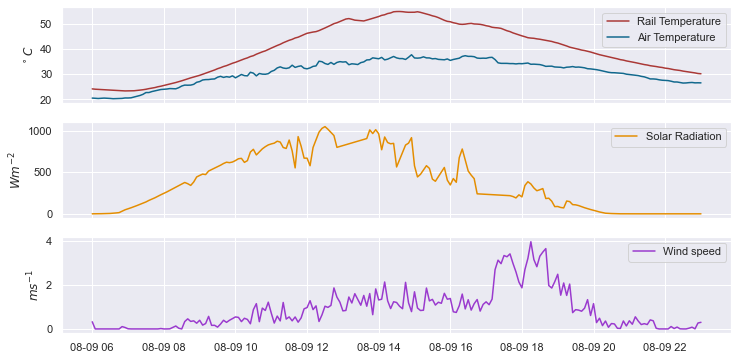

In [6]:
sns.set_theme()
fig, axes = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(12,6))
axes[0].plot(df.index,df['RT1'],label='Rail Temperature',color='#AA3836')
axes[0].plot(df.index,df['TA'],label='Air Temperature',color='#11688D')
axes[0].set_ylabel('$^\circ C$')
axes[0].legend()

axes[1].plot(df.index,df['SR'],label='Solar Radiation',color='#E48D00')
axes[1].set_ylabel('$Wm^{-2}$')
axes[1].legend()

axes[2].plot(df.index,df['Wv_avg'],label='Wind speed',color='#9A3ACE')
axes[2].set_ylabel('$ms^{-1}$')
axes[2].legend()

As seen, the data is clear with no fault or missing values.  
The range is from 06:00 to 23:00 of 2020-08-09. 
This will be the total range of the simulation  
It's very important that **missing values** are not passed to the simulation, otherwise it will not run properly.

# Simulation

## Initializing components

First is necessary to define `RailMaterial` object in which contains material properties to later be assigned to a `Rail` object.  
The parameters are:
* Density in kg/m³
* solar absortion 
* emisivity 

In [7]:
steel = RailMaterial(density=7850,solar_absort=0.8,emissivity=0.7)

Now we need to create a `Rail` objected which will pack many information of the rail to be simulated, such as:  
* Section name
* Azimuth
* Position (lat,long, elevation)
* Cross section area
* convection, radiation areas
* ambient emissivity
* material property  

The list of availiable sections can be found in xxxxxxx.  

The position has to be in decimal degrees, in this example is in the city of Mirandela-Portugal.  

The input areas must be in m².  

The material property is the `RailMaterial` object in which we created before

In [8]:
UIC54 = Rail(name='UIC54',
             azimuth=93,lat=41.482628,long=-7.183741,elev=220,
             cross_area=7.16e-3,convection_area=430.46e-3,radiation_area=430.46e-3,
             ambient_emissivity=0.5,material=steel)

Now is necessary to create a `WeatherData` object which packs:
* Solar radiation
* Wind velocity
* Ambient temperature
* Timezone information

Timzone information must be a `pytz.Timzone` object.  

We will use the dataframe `df` which we imported before. Each column will be a parameter of the `WeatherData` class initialization. It is imporant to mention that the dataframe must have the same `DateTimeIndex` to assure a issuless simulation run.



In [9]:
day1 = WeatherData(solar_radiation=df['SR'],
                   wind_velocity=df['Wv_avg'],
                   ambient_temperature=df['TA'],
                   timezone=pytz.timezone('Europe/Lisbon'))

The last object we need to create is a `CNU` object, which contains the methods to perform and output the solution.  
To create is necessary to pass the forementioned objects: `UIC54` which have the material and geometry info and `day1` that have all the datetime and ambient information.  

In [10]:
simu1 = CNU(rail=UIC54,weather=day1)

Once the `CNU` object is created, simply call the method `CNU.run` to run the simulation.

The only parameter needed is the initial rail temperature in Celsius.  
After, the programm will do all the calculations and the result will be availiable on `CNU.result`

## Running simulation

In [26]:
simu1.run_fixed_area(Trail_initial=23,Area=0.236)

Converting the temperatures to Kelvin
Done
Calculating Hconv
Done
Fetching solar data


C:\Anaconda3\lib\site-packages\pysolar\solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


Done
Calculating As
Done
Creating Delta time Columns
Done
Setting initial conditions
Done
Solving model
Done
Converting temperatures to Celsius
Done
Finished in: 2021-08-11 14:58:32.732656
Execution time: 1.5495541095733643
------------------------------------


In [27]:
simu1.result

,SR,Tamb,Wv,Hconv,Sun_azimuth,Sun_altitude,As,Delta_time,Simu_time,Tr_simu
Date,,,,,,,,,,
2020-08-09 06:00:00,0.05597,20.55713,0.32539,6.90156,62.590718,-6.237632,0.236,0,0,23.000000
2020-08-09 06:05:00,0.22490,20.45899,0.00000,5.60000,63.462800,-5.403703,0.236,300,300,22.903468
2020-08-09 06:10:00,0.64481,20.39551,0.00000,5.60000,64.327517,-4.563427,0.236,300,600,22.809126
2020-08-09 06:15:00,1.48352,20.47071,0.00000,5.60000,65.185217,-3.717047,0.236,300,900,22.723087
2020-08-09 06:20:00,2.41260,20.55078,0.00000,5.60000,66.036248,-2.864800,0.236,300,1200,22.645421
...,...,...,...,...,...,...,...,...,...,...
2020-08-09 22:40:00,0.00000,26.65577,0.03462,5.73848,314.989909,-20.263250,0.236,300,60000,30.836404
2020-08-09 22:45:00,0.00000,26.72022,0.07996,5.91984,316.068485,-20.920188,0.236,300,60300,30.671884
2020-08-09 22:50:00,0.00000,26.56690,0.00543,5.62172,317.160549,-21.564357,0.236,300,60600,30.513645


## Plotting results

Joining the df and result dataframes to ease the plot

In [28]:
result = simu1.result
result = result.join(df['RT1'])

In [29]:
result.head()

,SR,Tamb,Wv,Hconv,Sun_azimuth,Sun_altitude,As,Delta_time,Simu_time,Tr_simu,RT1
Date,,,,,,,,,,,
2020-08-09 06:00:00,0.05597,20.55713,0.32539,6.90156,62.590718,-6.237632,0.236,0,0,23.000000,24.189
2020-08-09 06:05:00,0.22490,20.45899,0.00000,5.60000,63.462800,-5.403703,0.236,300,300,22.903468,24.060
2020-08-09 06:10:00,0.64481,20.39551,0.00000,5.60000,64.327517,-4.563427,0.236,300,600,22.809126,23.990
2020-08-09 06:15:00,1.48352,20.47071,0.00000,5.60000,65.185217,-3.717047,0.236,300,900,22.723087,23.924
2020-08-09 06:20:00,2.41260,20.55078,0.00000,5.60000,66.036248,-2.864800,0.236,300,1200,22.645421,23.860


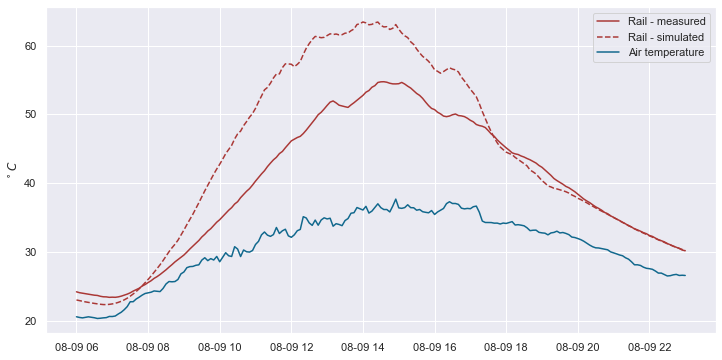

In [30]:
data = result
sns.set_theme()
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,6))

axes.plot(data.index,data['RT1'],label='Rail - measured',color='#AA3836')
axes.plot(data.index,data['Tr_simu'],label='Rail - simulated',color='#AA3836',ls='--')
axes.plot(df.index,df['TA'],label='Air temperature',color='#11688D')
axes.set_ylabel('$^\circ C$')
axes.legend()

# Simulation metrics

In [73]:
from sklearn.metrics import max_error,r2_score,mean_squared_error

In [74]:
data = result

In [75]:
print('n. of samples: ' + str(len(data)))
print('r2: ' + str(r2_score(data['RT1'],data['Tr_simu'])))
print('max error: '+str(max_error(data['RT1'],data['Tr_simu'])))
print('RMSE: '+str(mean_squared_error(data['RT1'],data['Tr_simu'])))

n. of samples: 205
r2: 0.9269487345632546
max error: 5.852009344946495
RMSE: 7.0740054804455434


C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='RT1', ylabel='Tr_simu'>

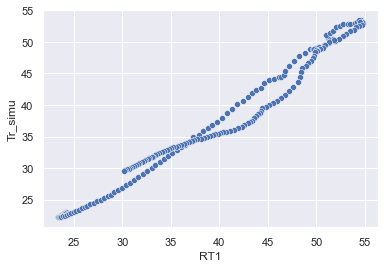

In [76]:
sns.scatterplot(data['RT1'],data['Tr_simu'])